In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## The forward and backward passes

In [2]:
#export
from utils.nb_functions import *

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))


In [3]:
def normalize(x, m, s): 
    return (x-m)/s

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [6]:
x_train = normalize(x_train, train_mean, train_std)
# NB: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

In [7]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(3.0614e-05), tensor(1.))

In [8]:
#export
def test_near_zero(a,tol=1e-3): 
    assert a.abs()<tol, f"Near zero: {a}"

In [9]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [10]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

## Foundations version

### Basic architecture

In [11]:
# num hidden
nh = 50

In [12]:
p=torch.randn(m)

In [13]:
print(len(p))
p[0]

784


tensor(0.6795)

In [14]:
p = torch.randn(m,nh)

In [15]:
print(len(p))
p[0]

784


tensor([ 0.0479,  0.2050,  1.8982, -1.4942,  0.2336, -0.2794, -0.2325,  0.0635,
         1.6185,  0.7008, -0.0250,  0.2083, -0.8319, -3.4070,  0.3106, -0.0699,
        -0.0290,  1.4189, -0.7157, -1.2027,  0.8504,  0.9953,  0.8741, -0.5195,
        -0.9736, -0.7772,  0.0355,  0.1212,  1.6448, -0.1492, -1.5018, -0.8820,
        -0.1374,  0.4971,  1.7200,  0.7020,  0.0377,  0.7133, -1.7655, -0.2964,
         0.5844,  1.5192, -0.9630,  0.1855,  1.7886,  1.7720,  0.3690, -0.3704,
         1.4356,  0.6534])

In [16]:
p[0].shape

torch.Size([50])

In [17]:
# simplified kaiming init / he init
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [18]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [19]:
w1.std()

tensor(0.0357)

In [20]:
# This should be ~ (0,1) (mean,std)...
x_valid.mean(),x_valid.std()

(tensor(-0.0058), tensor(0.9924))

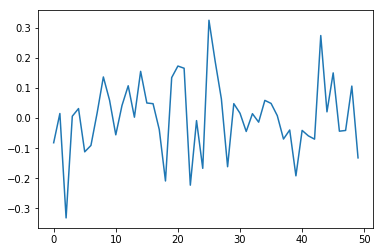

In [21]:
plt.plot(w2)

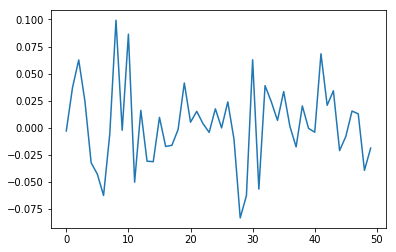

In [22]:
plt.plot(w1[0])

In [23]:
def lin(x, w, b): 
    return x@w + b

In [24]:
type(w1)

torch.Tensor

In [25]:
tw1=torch.t(w1)

In [26]:
w1@tw1

tensor([[ 0.0694, -0.0108,  0.0037,  ..., -0.0120, -0.0011, -0.0082],
        [-0.0108,  0.0498, -0.0070,  ...,  0.0110, -0.0030,  0.0042],
        [ 0.0037, -0.0070,  0.0387,  ..., -0.0161, -0.0047,  0.0105],
        ...,
        [-0.0120,  0.0110, -0.0161,  ...,  0.0611,  0.0017, -0.0027],
        [-0.0011, -0.0030, -0.0047,  ...,  0.0017,  0.0610,  0.0081],
        [-0.0082,  0.0042,  0.0105,  ..., -0.0027,  0.0081,  0.0674]])

In [27]:
t = lin(x_valid, w1, b1)

In [28]:
t

tensor([[ 0.1828, -0.6964, -0.5447,  ...,  0.4878, -1.0164,  1.0725],
        [-0.4327,  0.0613,  1.1093,  ...,  1.5012, -0.9411,  1.6726],
        [-0.6076,  0.5884,  0.5384,  ...,  0.3252,  1.2574, -1.1167],
        ...,
        [ 1.2266,  0.0786,  0.5533,  ...,  1.0301,  0.1220,  0.8117],
        [-0.1990, -0.5068, -0.5511,  ...,  0.1399,  0.9323, -0.0236],
        [ 0.9700,  1.0720,  0.7460,  ..., -0.3054,  0.5542,  0.1440]])

In [29]:
#...so should this, because we used kaiming init, which is designed to do this
t.mean(),t.std()

(tensor(-0.0887), tensor(1.0017))

In [30]:
def relu(x): 
    return x.clamp_min(0.)

In [31]:
t = relu(lin(x_valid, w1, b1))

In [32]:
#...actually it really should be this!
t.mean(),t.std()

(tensor(0.3511), tensor(0.5689))

From pytorch docs: `a: the negative slope of the rectifier used after this layer (0 for ReLU by default)`

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

This was introduced in the paper that described the Imagenet-winning approach from *He et al*: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852), which was also the first paper that claimed "super-human performance" on Imagenet (and, most importantly, it introduced resnets!)

In [33]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2/m)

In [34]:
w1.mean(),w1.std()

(tensor(-0.0001), tensor(0.0503))

In [35]:
t = relu(lin(x_valid, w1, b1))
t.mean(),t.std()

(tensor(0.5351), tensor(0.8157))

In [36]:
#export
from torch.nn import init

In [37]:
w1 = torch.zeros(m,nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_valid, w1, b1))

In [38]:
init.kaiming_normal_??

In [39]:
w1.mean(),w1.std()

(tensor(0.0003), tensor(0.0504))

In [40]:
t.mean(),t.std()

(tensor(0.6236), tensor(0.8776))

In [41]:
w1.shape

torch.Size([784, 50])

In [42]:
import torch.nn

In [43]:
torch.nn.Linear(m,nh).weight.shape

torch.Size([50, 784])

In [44]:
torch.nn.Linear.forward??

In [45]:
torch.nn.functional.linear??

In [46]:
torch.nn.Conv2d??

In [47]:
torch.nn.modules.conv._ConvNd.reset_parameters??

In [48]:
# what if...?
def relu(x): return x.clamp_min(0.) - 0.5

In [49]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2./m )
t1 = relu(lin(x_valid, w1, b1))
t1.mean(),t1.std()

(tensor(0.0308), tensor(0.7887))

In [50]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [51]:
%timeit -n 10 _=model(x_valid)

7.93 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
assert model(x_valid).shape==torch.Size([x_valid.shape[0],1])

### Loss function: MSE

In [53]:
model(x_valid).shape

torch.Size([10000, 1])

We need `squeeze()` to get rid of that trailing (,1), in order to use `mse`. (Of course, `mse` is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use `mse` for now to keep things simple.)

In [54]:
#export
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [55]:
y_train,y_valid = y_train.float(),y_valid.float()

In [56]:
preds = model(x_train)

In [57]:
preds.shape

torch.Size([50000, 1])

In [58]:
mse(preds, y_train)

tensor(28.6718)

### Gradients and backward pass

In [59]:
def mse_grad(inp, targ): 
    # grad of loss with respect to output of previous layer
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [60]:
def relu_grad(inp, out):
    # grad of relu with respect to input activations
    inp.g = (inp>0).float() * out.g

In [61]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [62]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    # we don't actually need the loss in backward!
    loss = mse(out, targ)
    
    # backward pass:
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [63]:
forward_and_backward(x_train, y_train)

In [64]:
# Save for testing against later
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = x_train.g.clone()

We cheat a little bit and use PyTorch autograd to check our results.

In [65]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [66]:
def forward(inp, targ):
    # forward pass:
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    # we don't actually need the loss in backward!
    return mse(out, targ)

In [67]:
loss = forward(xt2, y_train)

In [68]:
loss.backward()

In [69]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig )

## Refactor model

### Layers as classes

In [70]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)-0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [71]:
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp@self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        # Creating a giant outer product, just to sum it, is inefficient!
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [72]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [73]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [74]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [75]:
%time loss = model(x_train, y_train)

CPU times: user 89.5 ms, sys: 403 µs, total: 89.9 ms
Wall time: 44.5 ms


In [76]:
%time model.backward()

CPU times: user 3.27 s, sys: 2.37 s, total: 5.64 s
Wall time: 2.82 s


In [77]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

### Module.forward()

In [78]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [79]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [80]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [81]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [82]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [83]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [84]:
%time loss = model(x_train, y_train)

CPU times: user 77.1 ms, sys: 1.86 ms, total: 79 ms
Wall time: 39.1 ms


In [85]:
%time model.backward()

CPU times: user 189 ms, sys: 36.3 ms, total: 225 ms
Wall time: 112 ms


In [86]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

### Without einsum

In [87]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [88]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [89]:
%time loss = model(x_train, y_train)

CPU times: user 77.1 ms, sys: 1.8 ms, total: 78.9 ms
Wall time: 39 ms


In [90]:
%time model.backward()

CPU times: user 183 ms, sys: 46.1 ms, total: 229 ms
Wall time: 114 ms


In [91]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

### nn.Linear and nn.Module

In [92]:
#export
from torch import nn

In [93]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [94]:
model = Model(m, nh, 1)

In [95]:
%time loss = model(x_train, y_train)

CPU times: user 77.7 ms, sys: 558 µs, total: 78.3 ms
Wall time: 42.9 ms


In [96]:
%time loss.backward()

CPU times: user 152 ms, sys: 26.8 ms, total: 179 ms
Wall time: 59.5 ms


## Export

In [97]:
#!./notebook2script.py 02_fully_connected.ipynb

Traceback (most recent call last):
  File "./notebook2script.py", line 72, in <module>
    if __name__ == '__main__': fire.Fire(notebook2script)
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/fire/core.py", line 127, in Fire
    component_trace = _Fire(component, args, context, name)
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/fire/core.py", line 366, in _Fire
    component, remaining_args)
  File "/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/fire/core.py", line 542, in _CallCallable
    result = fn(*varargs, **kwargs)
  File "./notebook2script.py", line 45, in notebook2script
    if not allFiles: notebook2scriptSingle(fname)
  File "./notebook2script.py", line 56, in notebook2scriptSingle
    main_dic = json.load(open(fname,'r'))
FileNotFoundError: [Errno 2] No such file or directory: '02_fully_connected.ipynb'
